# Multilayer Perceptron for Financial Forecasting

A comprehensive analysis using polynomial detrending, seasonal differencing, and neural networks for time series prediction.

In [7]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid  

excel_file = 'M3C.xls'
sheet_name = "M3Month"
category = "FINANCE"

In [8]:
data = pd.read_excel(excel_file, sheet_name=sheet_name)
print("Loaded {}".format(sheet_name))

Loaded M3Month


1. Select how many time series to train on 

In [9]:
# Select N series to train on
category_data = data[data['Category'].str.strip() == category]
N = 50  

print(f"Training on {N} time series combined")
print(f"Total available: {len(category_data)} series\n")  

Training on 50 time series combined
Total available: 145 series



2. Process all the series chosen and combine their training sequences

In [10]:

# Store all training sequences 
all_X_train = []
all_y_train = []
all_training_data = []  # Store all data before the scaling

# Collect all the data for the global scaling
for idx in range(N):
    series = category_data.iloc[idx, 6:].dropna().astype(float)
    series_id = category_data.iloc[idx, 0]
    
    print(f"Processing series {idx+1}/{N}: {series_id} (length: {len(series)})")
    
    # Split and detrend
    y = series.values
    train_size = len(y) - 18
    
    poly = PolynomialFeatures(degree=2)
    X_train_indices = np.arange(train_size).reshape(-1, 1)
    X_all_indices = np.arange(len(y)).reshape(-1, 1)
    
    x_poly_train = poly.fit_transform(X_train_indices)
    poly_model = LinearRegression()
    poly_model.fit(x_poly_train, y[:train_size])
    
    x_poly_all = poly.transform(X_all_indices)
    poly_trend = poly_model.predict(x_poly_all)
    de_trended = y - poly_trend
    
    # Seasonal differencing
    months_in_year = 12
    seasonal_diff = []
    for i in range(months_in_year, len(de_trended)):
        value = de_trended[i] - de_trended[i - months_in_year]
        seasonal_diff.append(value)
    
    seasonal_diff_array = np.array(seasonal_diff)
    train_portion = seasonal_diff_array[:-18]
    
    all_training_data.append(train_portion)

# Global sacler on the combined data
global_scaler = StandardScaler()
combined_training = np.concatenate(all_training_data)
global_scaler.fit(combined_training.reshape(-1, 1))

print(f"Global scaler fitted on {len(combined_training)} data points")
print(f"Mean: {global_scaler.mean_[0]:.4f}, Std: {global_scaler.scale_[0]:.4f}\n")

# scale and create sequences for each series
for idx in range(N):
    series = category_data.iloc[idx, 6:].dropna().astype(float)
    series_id = category_data.iloc[idx, 0]
    
    y = series.values
    train_size = len(y) - 18
    
    poly = PolynomialFeatures(degree=2)
    X_train_indices = np.arange(train_size).reshape(-1, 1)
    X_all_indices = np.arange(len(y)).reshape(-1, 1)
    
    x_poly_train = poly.fit_transform(X_train_indices)
    poly_model = LinearRegression()
    poly_model.fit(x_poly_train, y[:train_size])
    
    x_poly_all = poly.transform(X_all_indices)
    poly_trend = poly_model.predict(x_poly_all)
    de_trended = y - poly_trend
    
    months_in_year = 12
    seasonal_diff = []
    for i in range(months_in_year, len(de_trended)):
        value = de_trended[i] - de_trended[i - months_in_year]
        seasonal_diff.append(value)
    
    seasonal_diff_array = np.array(seasonal_diff)
    train_portion = seasonal_diff_array[:-18]
    
    # global scaling
    training_data = global_scaler.transform(train_portion.reshape(-1, 1)).flatten()
    
    
    def create_sequences(data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback):
            X.append(data[i:i + lookback])
            y.append(data[i + lookback])
        return np.array(X), np.array(y)
    
    X_train, y_train = create_sequences(training_data, lookback=12)
    
    all_X_train.append(X_train)
    all_y_train.append(y_train)
    
    print(f"  → Generated {len(X_train)} training sequences")

# Combine all the sequences
X_train_combined = np.vstack(all_X_train)
y_train_combined = np.concatenate(all_y_train)

print(f"\n{'='*60}")
print(f"Combined training dataset:")
print(f"X_train shape: {X_train_combined.shape}")
print(f"y_train shape: {y_train_combined.shape}")
print(f"Total sequences: {len(X_train_combined)} (from {N} series)")
print(f"{'='*60}")

Processing series 1/50: N2522 (length: 143)
Processing series 2/50: N2523 (length: 144)
Processing series 3/50: N2524 (length: 144)
Processing series 4/50: N2525 (length: 144)
Processing series 5/50: N2526 (length: 144)
Processing series 6/50: N2527 (length: 144)
Processing series 7/50: N2528 (length: 134)
Processing series 8/50: N2529 (length: 134)
Processing series 9/50: N2530 (length: 134)
Processing series 10/50: N2531 (length: 134)
Processing series 11/50: N2532 (length: 134)
Processing series 12/50: N2533 (length: 134)
Processing series 13/50: N2534 (length: 134)
Processing series 14/50: N2535 (length: 134)
Processing series 15/50: N2536 (length: 134)
Processing series 16/50: N2537 (length: 134)
Processing series 17/50: N2538 (length: 134)
Processing series 18/50: N2539 (length: 134)
Processing series 19/50: N2540 (length: 134)
Processing series 20/50: N2541 (length: 134)
Processing series 21/50: N2542 (length: 122)
Processing series 22/50: N2543 (length: 134)
Processing series 2

3. Class for the multilayer perceptron

In [11]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.005, l2_lambda=0.0):
        
        self.weight_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.weight_output = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda  
        self.losses = []

    # In our implementation we chose the tanh activation function for the hidden layer
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x) ** 2

    def forward(self, X):
        # Hidden layer with tanh activation function
        self.hidden_input = X @ self.weight_hidden + self.bias_hidden
        self.hidden_output = self.tanh(self.hidden_input)
        
        # No activation function for the output, since we are doing regression
        self.final_input = self.hidden_output @ self.weight_output + self.bias_output
        self.final_output = self.final_input  
        
        return self.final_output
    
    def backward(self, X, y, output):
        m = X.shape[0]  # sample size
        
        # reshape to match output shape
        y = y.reshape(-1, 1)
        
        output_error = output - y  
        
        # Hidden layer gradient
        hidden_error = np.dot(output_error, self.weight_output.T) * self.tanh_derivative(self.hidden_input)
        
        # weights and bias update with L2 regularization
        self.weight_output -= self.learning_rate * (np.dot(self.hidden_output.T, output_error) / m + (self.l2_lambda / m) * self.weight_output)
        self.bias_output -= self.learning_rate * np.sum(output_error, axis=0, keepdims=True) / m
        self.weight_hidden -= self.learning_rate * (np.dot(X.T, hidden_error) / m + (self.l2_lambda / m) * self.weight_hidden)
        self.bias_hidden -= self.learning_rate * np.sum(hidden_error, axis=0, keepdims=True) / m

    def train(self, X, y, epochs, patience=None, min_delta=1e-6):
        m = X.shape[0]  # Add this line - define m at the start of train()
        best_loss = float('inf')
        patience_counter = 0
        best_weights = None
        
        for epoch in tqdm(range(epochs), desc="Training progress"):

            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            self.backward(X, y, output)
            
            # MSE
            loss = np.mean((output - y.reshape(-1, 1)) ** 2)
            
            # L2 regularization for loss
            if self.l2_lambda > 0:
                l2_penalty = (self.l2_lambda / (2 * m)) * (np.sum(self.weight_hidden ** 2) + np.sum(self.weight_output ** 2))
                total_loss = loss + l2_penalty
                self.losses.append(total_loss)
            else:
                self.losses.append(loss)

            # Early stopping to avoid unnecessary training
            if patience is not None:
                if loss < best_loss - min_delta:
                    best_loss = loss
                    patience_counter = 0

                    # Save best weights
                    best_weights = {
                        'weight_hidden': self.weight_hidden.copy(),
                        'weight_output': self.weight_output.copy(),
                        'bias_hidden': self.bias_hidden.copy(),
                        'bias_output': self.bias_output.copy()
                    }
                else:
                    patience_counter += 1
                
                # Stop if patience exceeded
                if patience_counter >= patience:
                    tqdm.write(f"\nEarly stopping at epoch {epoch+1}")
                    tqdm.write(f"Best loss: {best_loss:.6f}")

                    # Restore best weights
                    if best_weights:
                        self.weight_hidden = best_weights['weight_hidden']
                        self.weight_output = best_weights['weight_output']
                        self.bias_hidden = best_weights['bias_hidden']
                        self.bias_output = best_weights['bias_output']
                    break
            
            # progress bars B)
            if (epoch+1) % 30000 == 0:
                if patience is not None:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}, Best: {best_loss:.6f}, Patience: {patience_counter}/{patience}")
                else:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss (MSE): {loss:.6f}")

        tqdm.write(f"Final loss: {loss:.10f}")
        
    def predict(self, X):
        output = self.forward(X)
        return output.flatten()
    


4. Hyperparameter tuning and training of the model

In [12]:
param_grid = {
    'hidden_size': [2, 3, 5],
    'learning_rate': [1e-4, 5e-4, 1e-3],
    'l2_lambda': [0.0, 1e-5, 1e-4]
}

# Validation split
val_split = int(0.8 * len(X_train_combined))
X_train_tune = X_train_combined[:val_split]
y_train_tune = y_train_combined[:val_split]
X_val = X_train_combined[val_split:]
y_val = y_train_combined[val_split:]

# Grid search
best_val_loss = float('inf')
best_params = None

print(f"Testing {len(ParameterGrid(param_grid))} hyperparameter combinations\n")

for params in ParameterGrid(param_grid):
    print(f"Testing: {params}")
    model_temp = MLP(input_size=12, output_size=1, **params)
    model_temp.train(X_train_tune, y_train_tune, epochs=20000, patience=500, min_delta=1e-6)
    
    val_pred = model_temp.predict(X_val)
    val_loss = np.mean((val_pred - y_val) ** 2)
    print(f"  Val MSE: {val_loss:.6f}\n")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params

print(f"Best params: {best_params}")
print(f"Best val MSE: {best_val_loss:.6f}\n")

# Train final model with best params on ALL data
print(f"Training final model with best params on all {len(X_train_combined)} sequences\n")
model = MLP(input_size=12, output_size=1, **best_params)
model.train(X_train_combined, y_train_combined, epochs=100000, patience=500, min_delta=1e-6)

Testing 27 hyperparameter combinations

Testing: {'hidden_size': 2, 'l2_lambda': 0.0, 'learning_rate': 0.0001}


Training progress: 100%|██████████| 20000/20000 [00:04<00:00, 4155.78it/s]


Final loss: 0.8751188209
  Val MSE: 0.331805

Testing: {'hidden_size': 2, 'l2_lambda': 0.0, 'learning_rate': 0.0005}


Training progress: 100%|██████████| 20000/20000 [00:04<00:00, 4180.81it/s]


Final loss: 0.7680782627
  Val MSE: 0.286089

Testing: {'hidden_size': 2, 'l2_lambda': 0.0, 'learning_rate': 0.001}


Training progress: 100%|██████████| 20000/20000 [00:05<00:00, 3428.28it/s]


Final loss: 0.6942744988
  Val MSE: 0.270346

Testing: {'hidden_size': 2, 'l2_lambda': 1e-05, 'learning_rate': 0.0001}


Training progress: 100%|██████████| 20000/20000 [00:05<00:00, 3350.20it/s]


Final loss: 0.9507518199
  Val MSE: 0.303514

Testing: {'hidden_size': 2, 'l2_lambda': 1e-05, 'learning_rate': 0.0005}


Training progress: 100%|██████████| 20000/20000 [00:05<00:00, 3342.82it/s]


Final loss: 0.6894759106
  Val MSE: 0.276326

Testing: {'hidden_size': 2, 'l2_lambda': 1e-05, 'learning_rate': 0.001}


Training progress: 100%|██████████| 20000/20000 [00:05<00:00, 3555.71it/s]


Final loss: 0.5835485472
  Val MSE: 0.243060

Testing: {'hidden_size': 2, 'l2_lambda': 0.0001, 'learning_rate': 0.0001}


Training progress: 100%|██████████| 20000/20000 [00:05<00:00, 3419.28it/s]


Final loss: 0.8114794787
  Val MSE: 0.310667

Testing: {'hidden_size': 2, 'l2_lambda': 0.0001, 'learning_rate': 0.0005}


Training progress: 100%|██████████| 20000/20000 [00:05<00:00, 3622.05it/s]


Final loss: 0.7784356956
  Val MSE: 0.304894

Testing: {'hidden_size': 2, 'l2_lambda': 0.0001, 'learning_rate': 0.001}


Training progress: 100%|██████████| 20000/20000 [00:05<00:00, 3801.01it/s]


Final loss: 0.5951531639
  Val MSE: 0.250275

Testing: {'hidden_size': 3, 'l2_lambda': 0.0, 'learning_rate': 0.0001}


Training progress: 100%|██████████| 20000/20000 [00:06<00:00, 3193.43it/s]


Final loss: 0.9776908357
  Val MSE: 0.437509

Testing: {'hidden_size': 3, 'l2_lambda': 0.0, 'learning_rate': 0.0005}


Training progress: 100%|██████████| 20000/20000 [00:06<00:00, 3070.99it/s]


Final loss: 0.7052724929
  Val MSE: 0.242424

Testing: {'hidden_size': 3, 'l2_lambda': 0.0, 'learning_rate': 0.001}


Training progress: 100%|██████████| 20000/20000 [00:06<00:00, 3011.00it/s]


Final loss: 0.6628697289
  Val MSE: 0.252268

Testing: {'hidden_size': 3, 'l2_lambda': 1e-05, 'learning_rate': 0.0001}


Training progress: 100%|██████████| 20000/20000 [00:07<00:00, 2807.48it/s]


Final loss: 0.8220248888
  Val MSE: 0.281638

Testing: {'hidden_size': 3, 'l2_lambda': 1e-05, 'learning_rate': 0.0005}


Training progress: 100%|██████████| 20000/20000 [00:07<00:00, 2682.29it/s]


Final loss: 0.7431522001
  Val MSE: 0.265826

Testing: {'hidden_size': 3, 'l2_lambda': 1e-05, 'learning_rate': 0.001}


Training progress: 100%|██████████| 20000/20000 [00:07<00:00, 2517.08it/s]


Final loss: 0.6468509170
  Val MSE: 0.256180

Testing: {'hidden_size': 3, 'l2_lambda': 0.0001, 'learning_rate': 0.0001}


Training progress: 100%|██████████| 20000/20000 [00:07<00:00, 2843.37it/s]


Final loss: 0.8595770458
  Val MSE: 0.342500

Testing: {'hidden_size': 3, 'l2_lambda': 0.0001, 'learning_rate': 0.0005}


Training progress: 100%|██████████| 20000/20000 [00:07<00:00, 2835.75it/s]


Final loss: 0.6170411561
  Val MSE: 0.262799

Testing: {'hidden_size': 3, 'l2_lambda': 0.0001, 'learning_rate': 0.001}


Training progress: 100%|██████████| 20000/20000 [00:07<00:00, 2674.52it/s]


Final loss: 0.7153086543
  Val MSE: 0.266830

Testing: {'hidden_size': 5, 'l2_lambda': 0.0, 'learning_rate': 0.0001}


Training progress: 100%|██████████| 20000/20000 [00:09<00:00, 2172.37it/s]


Final loss: 0.8287106533
  Val MSE: 0.365630

Testing: {'hidden_size': 5, 'l2_lambda': 0.0, 'learning_rate': 0.0005}


Training progress: 100%|██████████| 20000/20000 [00:09<00:00, 2070.56it/s]


Final loss: 0.7091725419
  Val MSE: 0.292704

Testing: {'hidden_size': 5, 'l2_lambda': 0.0, 'learning_rate': 0.001}


Training progress: 100%|██████████| 20000/20000 [00:09<00:00, 2041.99it/s]


Final loss: 0.6273710545
  Val MSE: 0.251576

Testing: {'hidden_size': 5, 'l2_lambda': 1e-05, 'learning_rate': 0.0001}


Training progress: 100%|██████████| 20000/20000 [00:09<00:00, 2072.77it/s]


Final loss: 0.7962334230
  Val MSE: 0.334329

Testing: {'hidden_size': 5, 'l2_lambda': 1e-05, 'learning_rate': 0.0005}


Training progress: 100%|██████████| 20000/20000 [00:10<00:00, 1890.84it/s]


Final loss: 0.7379576296
  Val MSE: 0.285718

Testing: {'hidden_size': 5, 'l2_lambda': 1e-05, 'learning_rate': 0.001}


Training progress: 100%|██████████| 20000/20000 [00:09<00:00, 2020.95it/s]


Final loss: 0.5879003492
  Val MSE: 0.267090

Testing: {'hidden_size': 5, 'l2_lambda': 0.0001, 'learning_rate': 0.0001}


Training progress: 100%|██████████| 20000/20000 [00:10<00:00, 1931.15it/s]


Final loss: 0.7555262378
  Val MSE: 0.308546

Testing: {'hidden_size': 5, 'l2_lambda': 0.0001, 'learning_rate': 0.0005}


Training progress: 100%|██████████| 20000/20000 [00:10<00:00, 1945.13it/s]


Final loss: 0.6144703519
  Val MSE: 0.259865

Testing: {'hidden_size': 5, 'l2_lambda': 0.0001, 'learning_rate': 0.001}


Training progress: 100%|██████████| 20000/20000 [00:08<00:00, 2278.33it/s]


Final loss: 0.6142123887
  Val MSE: 0.259186

Best params: {'hidden_size': 3, 'l2_lambda': 0.0, 'learning_rate': 0.0005}
Best val MSE: 0.242424

Training final model with best params on all 4632 sequences



Training progress:  30%|███       | 30308/100000 [00:12<00:39, 1752.43it/s]

Epoch 30000/100000, Loss: 0.576362, Best: 0.576362, Patience: 0/500


Training progress:  60%|██████    | 60365/100000 [00:25<00:15, 2477.59it/s]

Epoch 60000/100000, Loss: 0.537445, Best: 0.537446, Patience: 1/500


Training progress:  90%|█████████ | 90206/100000 [00:39<00:06, 1590.68it/s]

Epoch 90000/100000, Loss: 0.520734, Best: 0.520735, Patience: 2/500


Training progress: 100%|██████████| 100000/100000 [00:43<00:00, 2290.35it/s]

Final loss: 0.5170646028


In [ ]:

def forecast_multiple_steps(model, last_sequence, n_steps=18):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        next_value = model.predict(current_sequence.reshape(1, -1))[0]
        predictions.append(next_value)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value
    
    return np.array(predictions)

5. Plot forecasts for all N training series

In [20]:
# Forecasts for all series
print(f"Generating forecasts for all {N} training series\n")

results = []

for test_idx in range(N):
    series = category_data.iloc[test_idx, 6:].dropna().astype(float)
    series_id = category_data.iloc[test_idx, 0]
    
   
    y = series.values
    train_size = len(y) - 18
    
    poly = PolynomialFeatures(degree=2)
    X_train_indices = np.arange(train_size).reshape(-1, 1)
    X_all_indices = np.arange(len(y)).reshape(-1, 1)
    
    x_poly_train = poly.fit_transform(X_train_indices)
    poly_model = LinearRegression()
    poly_model.fit(x_poly_train, y[:train_size])
    
    x_poly_all = poly.transform(X_all_indices)
    poly_trend = poly_model.predict(x_poly_all)
    de_trended = y - poly_trend
    
    months_in_year = 12
    seasonal_diff = []
    for i in range(months_in_year, len(de_trended)):
        value = de_trended[i] - de_trended[i - months_in_year]
        seasonal_diff.append(value)
    
    seasonal_diff_array = np.array(seasonal_diff)
    train_portion = seasonal_diff_array[:-18]
    validation_portion = seasonal_diff_array[-18:]
    
    scaler = StandardScaler()
    scaler.fit(train_portion.reshape(-1, 1))
    training_data = scaler.transform(train_portion.reshape(-1, 1)).flatten()
    validation_data = scaler.transform(validation_portion.reshape(-1, 1)).flatten()
    
    # Forecast
    last_sequence = training_data[-12:]
    validation_predictions_scaled = forecast_multiple_steps(model, last_sequence, n_steps=18)
    
    # Reverse transformations
    validation_predictions_denorm = scaler.inverse_transform(
        validation_predictions_scaled.reshape(-1, 1)
    ).flatten()
    
    reference_values = de_trended[-(36):-18]
    validation_predictions_deseasoned = validation_predictions_denorm + reference_values
    
    validation_trend = poly_trend[-18:]
    validation_predictions_original = validation_predictions_deseasoned + validation_trend
    
    # Calculate metrics
    actuals = y[-18:]
    mse = np.mean((validation_predictions_original - actuals) ** 2)
    mape = np.mean(np.abs((validation_predictions_original - actuals) / actuals)) * 100
    
    results.append({
        'series_id': series_id,
        'actuals': actuals,
        'predictions': validation_predictions_original,
        'mse': mse,
        'mape': mape
    })
    
    print(f"Series {test_idx+1}/{N}: {series_id} - MSE: {mse:.2f}, MAPE: {mape:.2f}%")

print("\n Forecasts generated")

# Calculate average metrics
avg_mse = np.mean([r['mse'] for r in results])
avg_mape = np.mean([r['mape'] for r in results])

print(f"Average MSE across {N} series:  {avg_mse:.2f}")
print(f"Average MAPE across {N} series: {avg_mape:.2f}%")


Generating forecasts for all 50 training series

Series 1/50: N2522 - MSE: 96112.87, MAPE: 6.76%
Series 2/50: N2523 - MSE: 846567.80, MAPE: 16.62%
Series 3/50: N2524 - MSE: 482263.05, MAPE: 17.02%
Series 4/50: N2525 - MSE: 7474680.12, MAPE: 24.14%
Series 5/50: N2526 - MSE: 238649.53, MAPE: 8.27%
Series 6/50: N2527 - MSE: 1701073.69, MAPE: 16.98%
Series 7/50: N2528 - MSE: 204102.49, MAPE: 4.73%
Series 8/50: N2529 - MSE: 651135.93, MAPE: 11.51%
Series 9/50: N2530 - MSE: 584434.84, MAPE: 11.20%
Series 10/50: N2531 - MSE: 204103.29, MAPE: 4.73%
Series 11/50: N2532 - MSE: 2130213.92, MAPE: 26.92%
Series 12/50: N2533 - MSE: 11742274.92, MAPE: 47.10%
Series 13/50: N2534 - MSE: 2689609.15, MAPE: 23.85%
Series 14/50: N2535 - MSE: 2686709.15, MAPE: 24.29%
Series 15/50: N2536 - MSE: 626474.98, MAPE: 13.96%
Series 16/50: N2537 - MSE: 1472062.69, MAPE: 19.89%
Series 17/50: N2538 - MSE: 1045355.73, MAPE: 20.46%
Series 18/50: N2539 - MSE: 1662729.50, MAPE: 11.05%
Series 19/50: N2540 - MSE: 9151654.87

# 7. PLOT PLOT PLOT PLOT PLOT PLOT PLOT PLOT PLOT PLOT PLOT PLOT PLOT PLOT PLOT

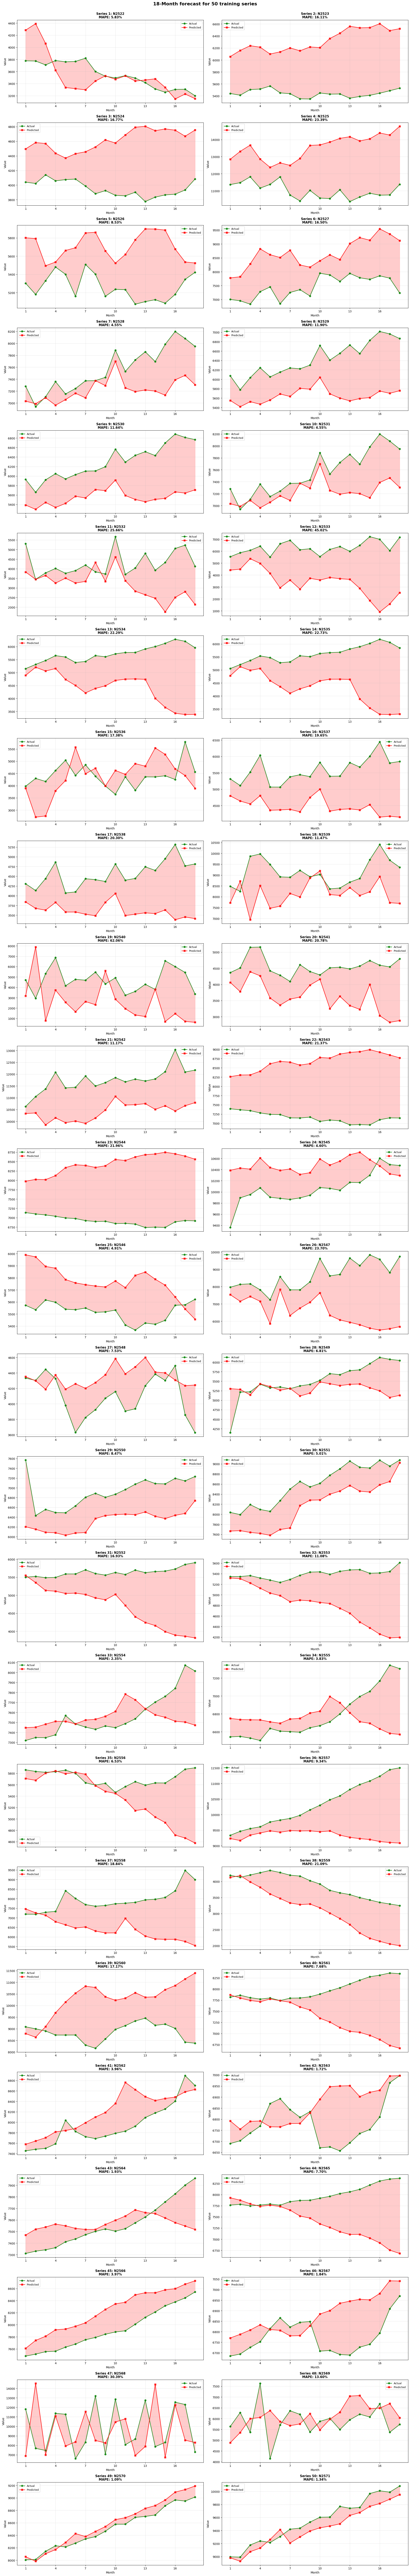

In [ ]:
# Plot all series 
rows = (N + 1) // 2  
fig, axes = plt.subplots(rows, 2, figsize=(20, 5 * rows))
axes = axes.flatten()

for idx, result in enumerate(results):
    ax = axes[idx]
    
    actuals = result['actuals']
    predictions = result['predictions']
    
    months = np.arange(1, 19)
    ax.plot(months, actuals, 'go-', linewidth=2, markersize=6, 
            label='Actual', alpha=0.8)
    ax.plot(months, predictions, 'rs-', linewidth=2, markersize=6, 
            label='Predicted', alpha=0.8)
    ax.fill_between(months, actuals, predictions, 
                     alpha=0.2, color='red')
    
    ax.set_title(f"Series {idx+1}: {result['series_id']}\nMAPE: {result['mape']:.2f}%", 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(months[::3])



plt.suptitle(f'18-Month forecast for {N} training series', 
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

8. Distributions and metrics 

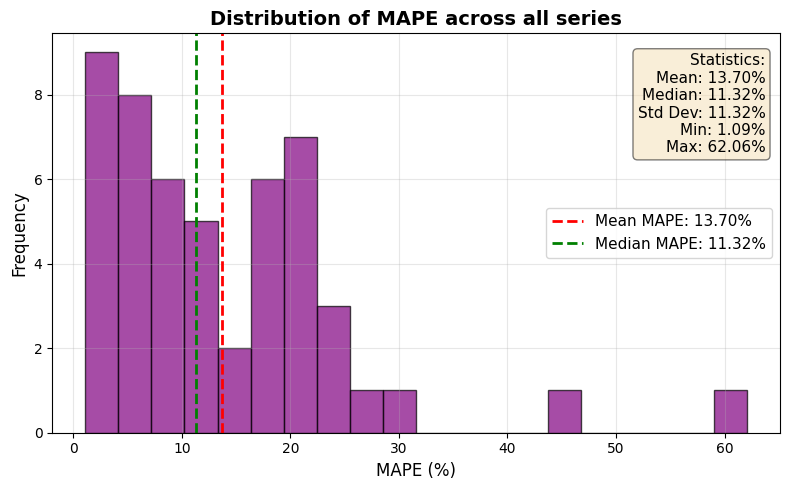


MAPE Error Distribution Analysis:
Mean MAPE:        13.70%
Median MAPE:      11.32%
Std Deviation:    11.32%
Min MAPE:         1.09%
Max MAPE:         62.06%
25th Percentile:  4.94%
75th Percentile:  20.13%

Top 5 Best Performing Series:
1. N2570: MAPE = 1.09%
2. N2571: MAPE = 1.34%
3. N2563: MAPE = 1.72%
4. N2567: MAPE = 1.84%
5. N2564: MAPE = 1.93%

Top 5 Worst Performing Series:
1. N2547: MAPE = 23.70%
2. N2532: MAPE = 25.66%
3. N2568: MAPE = 30.39%
4. N2533: MAPE = 45.02%
5. N2540: MAPE = 62.06%


In [ ]:
# Plot MAPE distribution (no box plots)
fig, ax = plt.subplots(figsize=(8, 5))

# Histogram
mape_values = [r['mape'] for r in results]
ax.hist(mape_values, bins=20, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(avg_mape, color='red', linestyle='--', linewidth=2, 
           label=f'Mean MAPE: {avg_mape:.2f}%')
ax.axvline(np.median(mape_values), color='green', linestyle='--', linewidth=2,
           label=f'Median MAPE: {np.median(mape_values):.2f}%')
ax.set_title('Distribution of MAPE across all series', fontsize=14, fontweight='bold')
ax.set_xlabel('MAPE (%)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add statistics text
stats_text = f"""Statistics:
Mean: {avg_mape:.2f}%
Median: {np.median(mape_values):.2f}%
Std Dev: {np.std(mape_values):.2f}%
Min: {np.min(mape_values):.2f}%
Max: {np.max(mape_values):.2f}%"""

ax.text(0.98, 0.95, stats_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print("MAPE Error Distribution Analysis:")
print(f"{'='*60}")
print(f"Mean MAPE:        {avg_mape:.2f}%")
print(f"Median MAPE:      {np.median(mape_values):.2f}%")
print(f"Std Deviation:    {np.std(mape_values):.2f}%")
print(f"Min MAPE:         {np.min(mape_values):.2f}%")
print(f"Max MAPE:         {np.max(mape_values):.2f}%")
print(f"25th Percentile:  {np.percentile(mape_values, 25):.2f}%")
print(f"75th Percentile:  {np.percentile(mape_values, 75):.2f}%")
print(f"{'='*60}")

# Show best and worst performing series
sorted_results = sorted(results, key=lambda x: x['mape'])
print("\nTop 5 Best Performing Series:")
for i, r in enumerate(sorted_results[:5], 1):
    print(f"{i}. {r['series_id']}: MAPE = {r['mape']:.2f}%")

print("\nTop 5 Worst Performing Series:")
for i, r in enumerate(sorted_results[-5:], 1):
    print(f"{i}. {r['series_id']}: MAPE = {r['mape']:.2f}%")
